This Notebook is going to go through some EDA of the London Bike Hire Data

Install Libraries


In [7]:
#Install necessary libraries
%pip install --upgrade google-cloud-bigquery pyarrow
%pip install pandas numpy matplotlib seaborn
%pip install db-dtypes
%pip install time datetime
%pip install scikit-learn
%pip install google-cloud-bigquery-storage

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement time (from versions: none)
ERROR: No matching distribution found for time


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Connect To The London Bike Hire Dataset


In [8]:
import os
import pandas as pd
from google.cloud import bigquery

# Set your GCP project and BigQuery location
project = "london-bike-hire-dataset-test"
location = "EU"

# Set path to your credentials JSON file (local path)
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"C:\Users\msidh\Documents\Coding\London Bicycle Hires App\credentials\bq_viewer_key.json"

# Initialise BigQuery client
client = bigquery.Client(project=project, location=location)

#List all tables in the london_bicycles dataset
#should return cycle_hire and cycle_stations

dataset_ref = client.dataset("london_bicycles", project="bigquery-public-data")
tables = client.list_tables(dataset_ref)

print("Tables in bigquery-public-data.london_bicycles:")
for table in tables:
    print(" -", table.table_id)


Tables in bigquery-public-data.london_bicycles:
 - cycle_hire
 - cycle_stations


In [57]:
# Load the last 5 rides (ordered by start_date DESC)
query = """
SELECT *
FROM `bigquery-public-data.london_bicycles.cycle_hire`
ORDER BY start_date DESC
LIMIT 5
"""

# Run query and load results into DataFrame
cycle_hire_df = client.query(query).to_dataframe()

# Load station metadata (no filtering needed)
cycle_stations_table = dataset_ref.table("cycle_stations")
cycle_stations_df = client.list_rows(cycle_stations_table).to_dataframe()

# Output result sizes
print("Cycle Hire (last 5):", cycle_hire_df.shape)
print("Cycle Stations:", cycle_stations_df.shape)

# Show sample data
print(cycle_hire_df.head())
print(cycle_hire_df.columns)

Cycle Hire (last 5): (5, 14)
Cycle Stations: (800, 13)
   rental_id  duration  duration_ms  bike_id bike_model  \
0  127942862      2109      2109437    15276    CLASSIC   
1  127942863      2346      2345800    59251    CLASSIC   
2  127942861      1219      1219120    53613    CLASSIC   
3  127942860      1458      1458468    31061    CLASSIC   
4  127942859      2109      2108817    20289    CLASSIC   

                   end_date  end_station_id                  end_station_name  \
0 2023-01-16 00:34:00+00:00            1007         Drury Lane, Covent Garden   
1 2023-01-16 00:39:00+00:00          300084             Sirdar Road, Avondale   
2 2023-01-16 00:19:00+00:00          200214  Woodstock Grove, Shepherd's Bush   
3 2023-01-16 00:23:00+00:00          200033       Philpot Street, Whitechapel   
4 2023-01-16 00:34:00+00:00            1007         Drury Lane, Covent Garden   

                 start_date  start_station_id  \
0 2023-01-15 23:59:00+00:00              1229   
1 202

Load Cleaned Data from the Silver Layer

In [1]:
import pandas as pd
from pathlib import Path

# Define path to Silver layer
silver_store = Path("storage/Silver")

# Load cleaned 2022 cycle hire trips
valid_trip_df = pd.read_parquet(silver_store / "cleaned_cycle_hire.parquet")

# Load cleaned station reference data
cleaned_stations_df = pd.read_parquet(silver_store / "cleaned_cycle_stations.parquet")

Data Analysis

Helper Function for plotting

In [4]:

import matplotlib.pyplot as plt
import pandas as pd

# Plotting helper function
def plot_vertical_bar_chart(df, x_col, y_col, title, xlabel, ylabel):
    plt.figure(figsize=(10, 5))
    bars = plt.bar(df[x_col], df[y_col], color="steelblue")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.01 * height,
            f"{height:,.0f}",
            ha="center",
            va="bottom",
            fontsize=8
        )

    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

Key Metrics for Data Exploration

In [5]:
# Compute key metrics
avg_duration_mins = valid_trip_df["duration"].mean() / 60  # convert seconds to minutes
total_duration_hours = valid_trip_df["duration"].sum() / 3600
unique_start_stations = valid_trip_df["start_station_id"].nunique()
unique_end_stations = valid_trip_df["end_station_id"].nunique()
total_unique_stations = cleaned_stations_df["id"].nunique()

print(f"Average Trip Duration: {avg_duration_mins:.2f} minutes")
print(f"Total Trip Time: {total_duration_hours:,.0f} hours")
print(f"Unique Start Stations: {unique_start_stations}")
print(f"Unique End Stations: {unique_end_stations}")
print(f"Total Unique Stations in Reference: {total_unique_stations}")

Average Trip Duration: 19.77 minutes
Total Trip Time: 2,670,682 hours
Unique Start Stations: 779
Unique End Stations: 779
Total Unique Stations in Reference: 800


Text(0.5, 1.0, 'Trip Duration Distribution (minutes)')

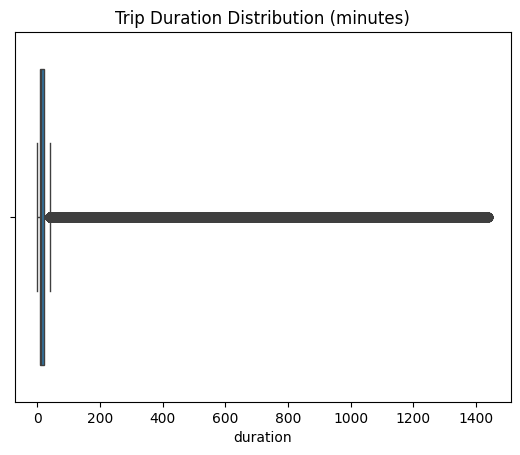

In [6]:
import seaborn as sns
sns.boxplot(x=valid_trip_df["duration"] / 60)  # convert to minutes
plt.title("Trip Duration Distribution (minutes)")

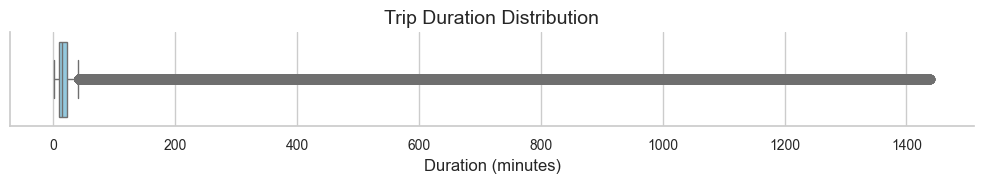

In [7]:
# Convert duration to minutes
valid_trip_df["duration_mins"] = valid_trip_df["duration"] / 60

# Optional: filter out trips longer than 2 hours (120 mins) to reduce skew
# Set Seaborn style
sns.set(style="whitegrid")

# Plot
plt.figure(figsize=(10, 2))  # Wide and short for a single boxplot
sns.boxplot(x=valid_trip_df["duration_mins"], color="skyblue")

# Titles and labels
plt.title("Trip Duration Distribution", fontsize=14)
plt.xlabel("Duration (minutes)", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks([])  # Hide y-axis ticks (optional for a clean look)

# Optional: remove top and right spines
sns.despine()

plt.tight_layout()
plt.show()

Mean trip duration:      19.77 minutes
Median trip duration:    14.00 minutes
90th percentile:         32.00 minutes
Lower outlier cutoff:    -10.50 minutes
Upper outlier cutoff:    41.50 minutes
Number of lower outliers: 0
Number of upper outliers: 514470


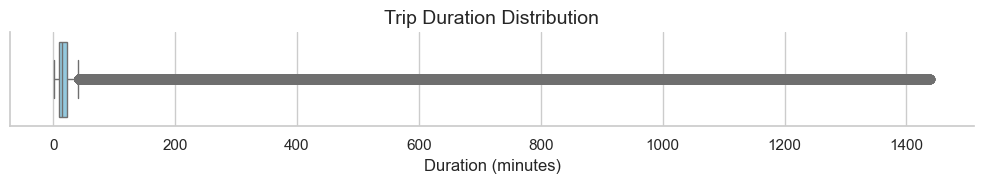

In [91]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Convert duration to minutes
valid_trip_df["duration_mins"] = valid_trip_df["duration"] / 60

# Calculate duration metrics
mean_duration = valid_trip_df["duration_mins"].mean()
median_duration = valid_trip_df["duration_mins"].median()
pct90_duration = valid_trip_df["duration_mins"].quantile(0.90)

# Calculate IQR for outlier definition
q1 = valid_trip_df["duration_mins"].quantile(0.25)
q3 = valid_trip_df["duration_mins"].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Count outliers
n_lower_outliers = (valid_trip_df["duration_mins"] < lower_bound).sum()
n_upper_outliers = (valid_trip_df["duration_mins"] > upper_bound).sum()

# Print the results
print(f"Mean trip duration:      {mean_duration:.2f} minutes")
print(f"Median trip duration:    {median_duration:.2f} minutes")
print(f"90th percentile:         {pct90_duration:.2f} minutes")
print(f"Lower outlier cutoff:    {lower_bound:.2f} minutes")
print(f"Upper outlier cutoff:    {upper_bound:.2f} minutes")
print(f"Number of lower outliers: {n_lower_outliers}")
print(f"Number of upper outliers: {n_upper_outliers}")

# Optional: filter out trips longer than 2 hours (120 mins) to reduce skew
sns.set(style="whitegrid")

# Plot
plt.figure(figsize=(10, 2))  # Wide and short for a single boxplot
sns.boxplot(x=valid_trip_df["duration_mins"], color="skyblue")

# Titles and labels
plt.title("Trip Duration Distribution", fontsize=14)
plt.xlabel("Duration (minutes)", fontsize=12)
plt.yticks([])  # Hide y-axis ticks for a clean look

# Remove top and right spines
sns.despine()

plt.tight_layout()
plt.show()


In [14]:
valid_trip_df["hour"] = pd.to_datetime(valid_trip_df["start_date"]).dt.hour
valid_trip_df["weekday"] = pd.to_datetime(valid_trip_df["start_date"]).dt.weekday

In [67]:
valid_trip_df.columns

Index(['rental_id', 'duration', 'duration_ms', 'bike_id', 'bike_model',
       'end_date', 'end_station_id', 'end_station_name', 'start_date',
       'start_station_id', 'start_station_name',
       'end_station_logical_terminal', 'start_station_logical_terminal',
       'end_station_priority_id', 'invalid_year', 'invalid_duration',
       'invalid_bike_id', 'invalid_start_station_id', 'invalid_end_station_id',
       'invalid_rental_id', 'hour', 'weekday', 'wk_index', 'weekday_name',
       'duration_mins'],
      dtype='object')

# Most Used Start Station

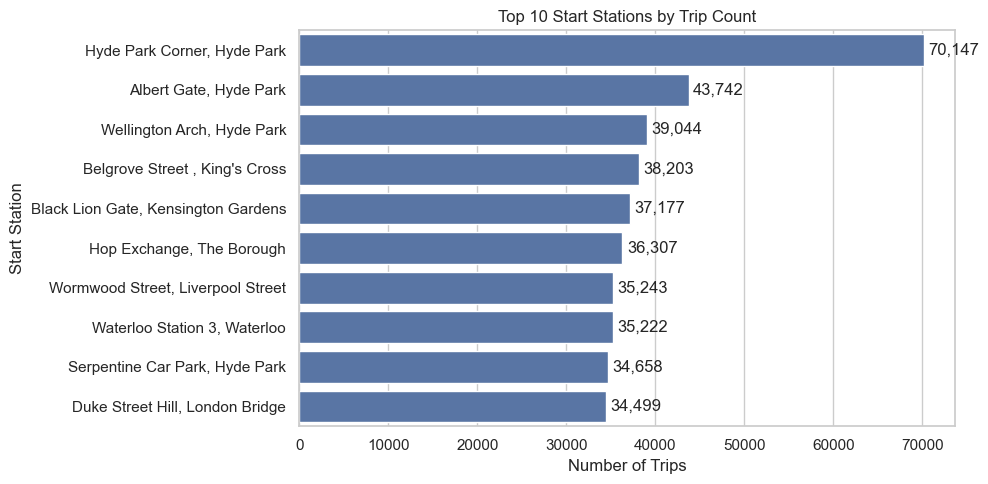

In [78]:
top_start = (
    valid_trip_df["start_station_name"]
    .value_counts()
    .head(10)                 # Top 10
    .sort_values(ascending=False)  # Ensure largest at top
)

plt.figure(figsize=(10, 5))
ax = sns.barplot(x=top_start.values, y=top_start.index)
plt.title("Top 10 Start Stations by Trip Count")
plt.xlabel("Number of Trips")
plt.ylabel("Start Station")

# Add value labels at end of bars
for i, v in enumerate(top_start.values):
    ax.text(v + 500, i, f"{v:,}", va="center")  # 500-trip offset for clarity

plt.tight_layout()
plt.show()

### Plot Top 10 Start Stations as % of Top-10 Trips

Top 10 Start Stations by Share of Top-10 Trips (2022):
                 start_station_name trip_count pct_of_top10
        Hyde Park Corner, Hyde Park     70,147        17.4%
             Albert Gate, Hyde Park     43,742        10.8%
         Wellington Arch, Hyde Park     39,044         9.7%
     Belgrove Street , King's Cross     38,203         9.5%
Black Lion Gate, Kensington Gardens     37,177         9.2%
          Hop Exchange, The Borough     36,307         9.0%
  Wormwood Street, Liverpool Street     35,243         8.7%
       Waterloo Station 3, Waterloo     35,222         8.7%
     Serpentine Car Park, Hyde Park     34,658         8.6%
    Duke Street Hill, London Bridge     34,499         8.5%


C:\Users\msidh\AppData\Local\Temp\ipykernel_32716\486474172.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


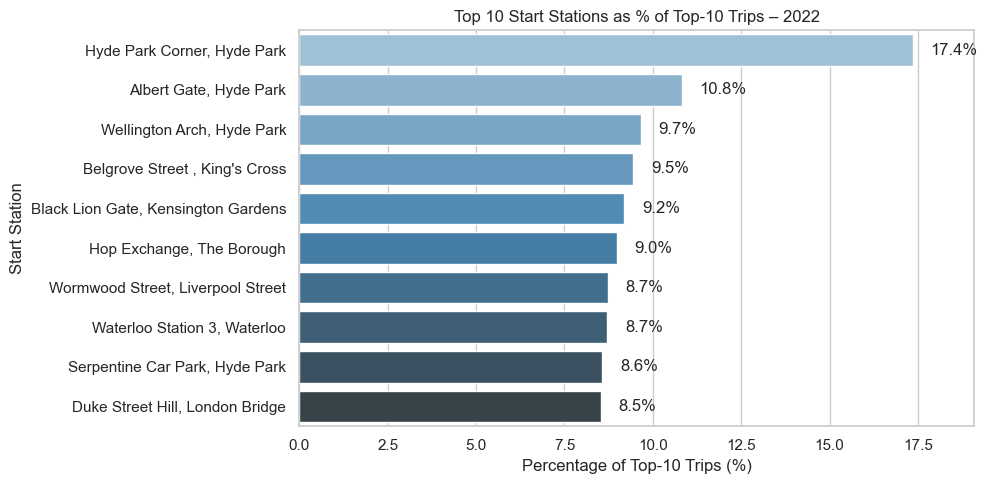

In [86]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate top 10 start stations by trip count
top_start = (
    valid_trip_df["start_station_name"]
    .value_counts()
    .head(10)                      # Top 10
    .sort_values(ascending=False)  # Ensure largest at top
)

# Turn into a DataFrame
top_start_df = top_start.reset_index()
top_start_df.columns = ["start_station_name", "trip_count"]

# Compute percentage of the top-10 group
total_top10 = top_start_df["trip_count"].sum()
top_start_df["pct_of_top10"] = top_start_df["trip_count"] / total_top10 * 100

# Display table
print("Top 10 Start Stations by Share of Top-10 Trips (2022):")
print(top_start_df.to_string(index=False, formatters={
    "trip_count": "{:,}".format,
    "pct_of_top10": lambda x: f"{x:.1f}%"
}))

# Plot
plt.figure(figsize=(10, 5))
ax = sns.barplot(
    x="pct_of_top10",
    y="start_station_name",
    data=top_start_df,
    palette="Blues_d"
)
plt.title("Top 10 Start Stations as % of Top-10 Trips – 2022")
plt.xlabel("Percentage of Top-10 Trips (%)")
plt.ylabel("Start Station")

# Add percentage labels
for i, pct in enumerate(top_start_df["pct_of_top10"]):
    ax.text(pct + 0.5, i, f"{pct:.1f}%", va="center")

plt.xlim(0, top_start_df["pct_of_top10"].max() * 1.1)
plt.tight_layout()
plt.show()


Top 10 Station Suffixes by % of All Trips in 2022:
station_suffix trip_count pct_of_all_trips
     Hyde Park    288,861             3.6%
    Marylebone    274,407             3.4%
   Westminster    187,974             2.3%
       Holborn    169,198             2.1%
        Strand    160,487             2.0%
       Mayfair    159,283             2.0%
    Bloomsbury    153,970             1.9%
      Waterloo    148,054             1.8%
 Knightsbridge    147,253             1.8%
    Kensington    146,793             1.8%


C:\Users\msidh\AppData\Local\Temp\ipykernel_32716\3173102970.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


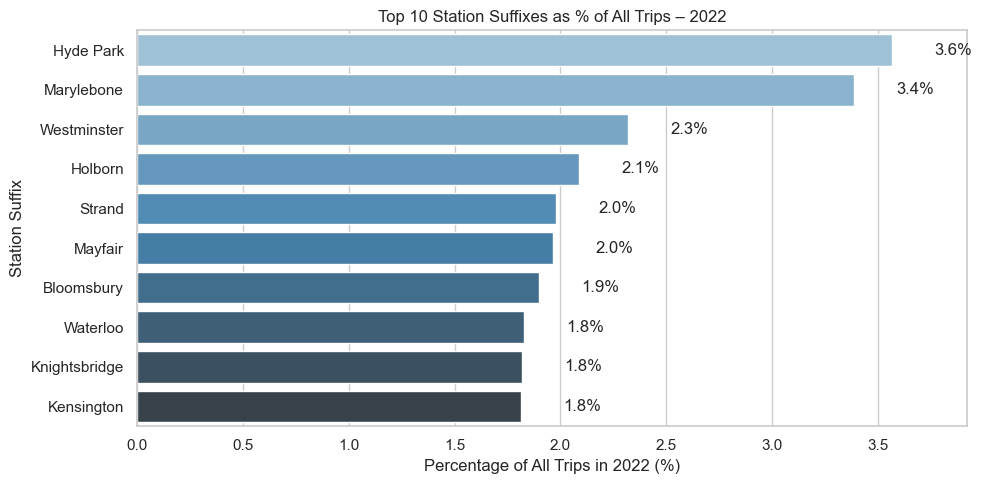

In [90]:
### Top 10 Station Suffixes as % of All Trips in 2022

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Use the full 2022 trip dataset
all_trips = valid_trip_df  # assumes this DataFrame holds all trips in 2022

# Extract the text after the first comma (or use full name if no comma)
suffix_series = all_trips["start_station_name"].str.split(",", n=1).str[1].str.strip()
suffix_series = suffix_series.fillna(all_trips["start_station_name"])

# Count trips per suffix and take top 10 by absolute count
top_suffix = (
    suffix_series
    .value_counts()
    .head(10)
    .sort_values(ascending=False)
)

# Build DataFrame
top_suffix_df = top_suffix.reset_index()
top_suffix_df.columns = ["station_suffix", "trip_count"]

# Compute percentage of all trips in 2022
total_trips_2022 = all_trips.shape[0]
top_suffix_df["pct_of_all_trips"] = top_suffix_df["trip_count"] / total_trips_2022 * 100

# Display table
print("Top 10 Station Suffixes by % of All Trips in 2022:")
print(top_suffix_df.to_string(index=False, formatters={
    "trip_count": "{:,}".format,
    "pct_of_all_trips": lambda x: f"{x:.1f}%"
}))

# Plot the percentages
plt.figure(figsize=(10, 5))
ax = sns.barplot(
    x="pct_of_all_trips",
    y="station_suffix",
    data=top_suffix_df,
    palette="Blues_d"
)
plt.title("Top 10 Station Suffixes as % of All Trips – 2022")
plt.xlabel("Percentage of All Trips in 2022 (%)")
plt.ylabel("Station Suffix")

# Add percentage labels at end of bars
for i, pct in enumerate(top_suffix_df["pct_of_all_trips"]):
    ax.text(pct + 0.2, i, f"{pct:.1f}%", va="center")

plt.xlim(0, top_suffix_df["pct_of_all_trips"].max() * 1.1)
plt.tight_layout()
plt.show()


# Most Used End Station

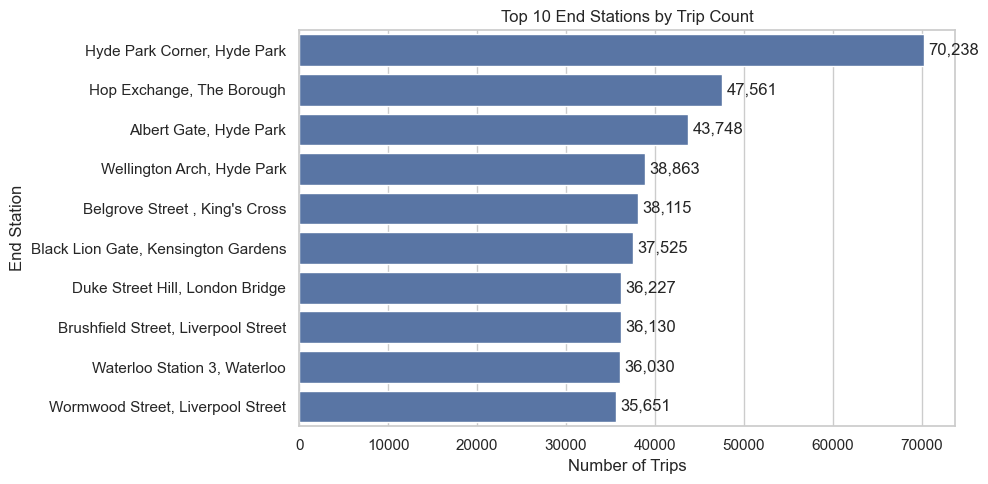

In [79]:
# Top-10 most-used end stations
top_end = (
    valid_trip_df["end_station_name"]
    .value_counts()
    .head(10)
    .sort_values(ascending=False)
)

plt.figure(figsize=(10, 5))
ax = sns.barplot(x=top_end.values, y=top_end.index)
plt.title("Top 10 End Stations by Trip Count")
plt.xlabel("Number of Trips")
plt.ylabel("End Station")

for i, v in enumerate(top_end.values):
    ax.text(v + 500, i, f"{v:,}", va="center")

plt.tight_layout()
plt.show()


# 10 Least used Start Stations

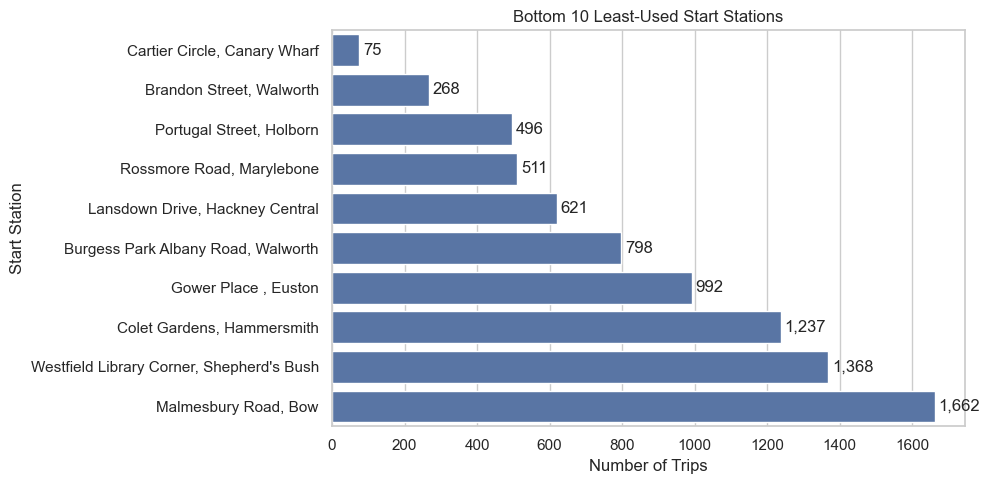

In [80]:
# Bottom-10 least-used start stations
least_start = (
    valid_trip_df["start_station_name"]
    .value_counts(ascending=True)
    .head(10)                     # 10 smallest
    .sort_values(ascending=True)  # keep smallest at top of chart
)

plt.figure(figsize=(10, 5))
ax = sns.barplot(x=least_start.values, y=least_start.index)
plt.title("Bottom 10 Least-Used Start Stations")
plt.xlabel("Number of Trips")
plt.ylabel("Start Station")

for i, v in enumerate(least_start.values):
    ax.text(v + 10, i, f"{v:,}", va="center")   # small offset (trips are low)

plt.tight_layout()
plt.show()


10 Least Used End Stations

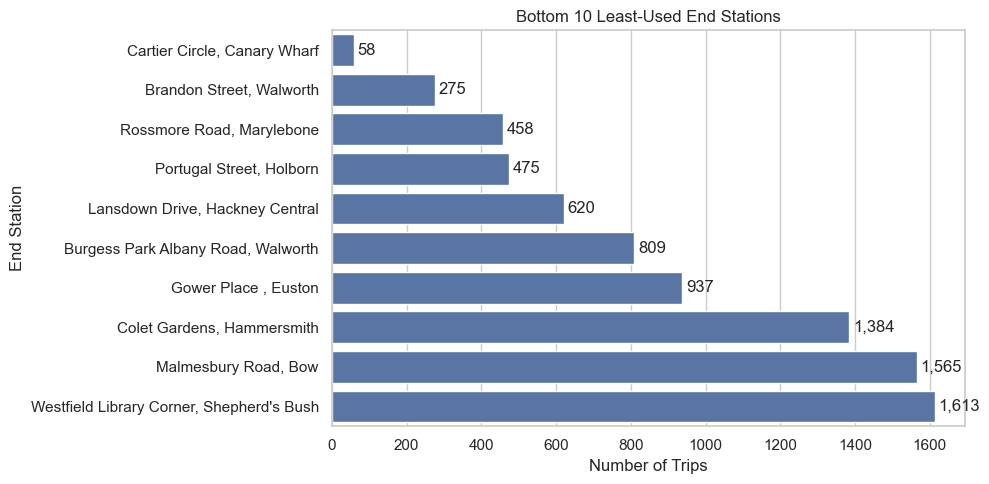

In [76]:
# Bottom-10 least-used end stations
least_end = (
    valid_trip_df["end_station_name"]
    .value_counts(ascending=True)
    .head(10)
    .sort_values(ascending=True)
)

plt.figure(figsize=(10, 5))
ax = sns.barplot(x=least_end.values, y=least_end.index)
plt.title("Bottom 10 Least-Used End Stations")
plt.xlabel("Number of Trips")
plt.ylabel("End Station")

for i, v in enumerate(least_end.values):
    ax.text(v + 10, i, f"{v:,}", va="center")

plt.tight_layout()
plt.show()


# Bike-rental demand by year

In [16]:
query_demand_by_year = """
WITH yearly AS (
  SELECT
    EXTRACT(YEAR FROM start_date) AS rental_year,   -- 2015, 2016, …
    COUNT(*)                       AS number_trips
  FROM `bigquery-public-data.london_bicycles.cycle_hire`
  GROUP BY rental_year
)
SELECT
  rental_year  AS year,
  number_trips
FROM yearly
ORDER BY rental_year;      -- ascending: earliest → latest
"""


In [17]:
df_yearly_demand = client.query(query_demand_by_year).to_dataframe()

In [18]:
df_yearly_demand

,year,number_trips
0,2015,9768810
1,2016,10212909
2,2017,10331874
3,2018,10441884
4,2019,10310063
5,2020,10287040
6,2021,10821289
7,2022,11027519
8,2023,233478


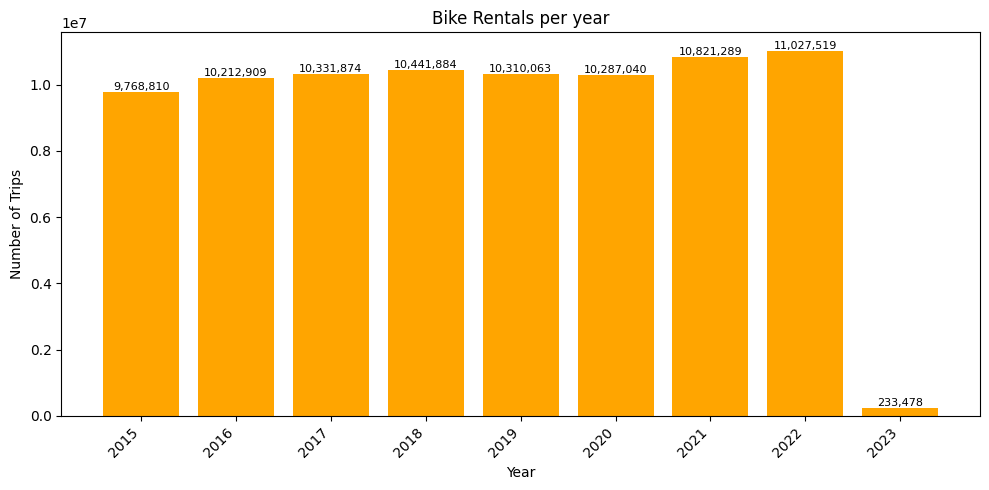

In [19]:
import matplotlib.pyplot as plt

years   = df_yearly_demand["year"].astype(str) 

plt.figure(figsize=(10, 5))
bars = plt.bar(years, df_yearly_demand["number_trips"], color="orange") #plot the x and y axis of a bar chart in orange
plt.title("Bike Rentals per year")
plt.xlabel("Year")
plt.ylabel("Number of Trips")
plt.xticks(years, rotation=45, ha="right")


for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:,.0f}",            # comma-separated integers
        ha="center",
        va="bottom",
        fontsize=8
    )

plt.tight_layout()
plt.show()

Bike-Hire demand by month across all years based on number of trips

In [20]:
query_demand_by_month = """
WITH monthly AS (
  SELECT
    EXTRACT(MONTH FROM start_date)           AS month_as_numeric,
    FORMAT_TIMESTAMP('%B', start_date)       AS month_name,          -- January, February etc
    COUNT(*)                                 AS number_trips
  FROM `bigquery-public-data.london_bicycles.cycle_hire`
  GROUP BY month_as_numeric, month_name
)
SELECT
  month_name  AS month,
  number_trips
FROM monthly
ORDER BY month_as_numeric;   -- keeps Jan to December 
"""

demand_cycle_hire = client.query(query_demand_by_month).to_dataframe()


In [21]:
demand_cycle_hire

,month,number_trips
0,January,5163182
1,February,4892555
2,March,5882848
3,April,6743679
4,May,8180251
5,June,8819041
6,July,9421707
7,August,8732997
8,September,7745282
9,October,7347014


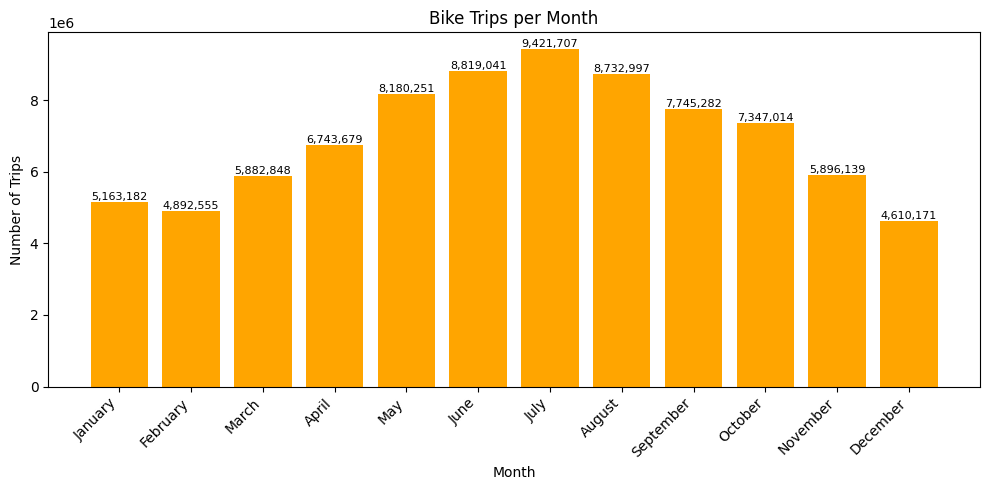

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
bars = plt.bar(demand_cycle_hire["month"], demand_cycle_hire["number_trips"], color="orange") #plot the x and y axis of a bar chart in orange
plt.title("Bike Trips per Month")
plt.xlabel("Month")
plt.ylabel("Number of Trips")
plt.xticks(rotation=45, ha="right")


for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:,.0f}",            # comma-separated integers
        ha="center",
        va="bottom",
        fontsize=8
    )

plt.tight_layout()
plt.show()

Bike Seasonal Demand

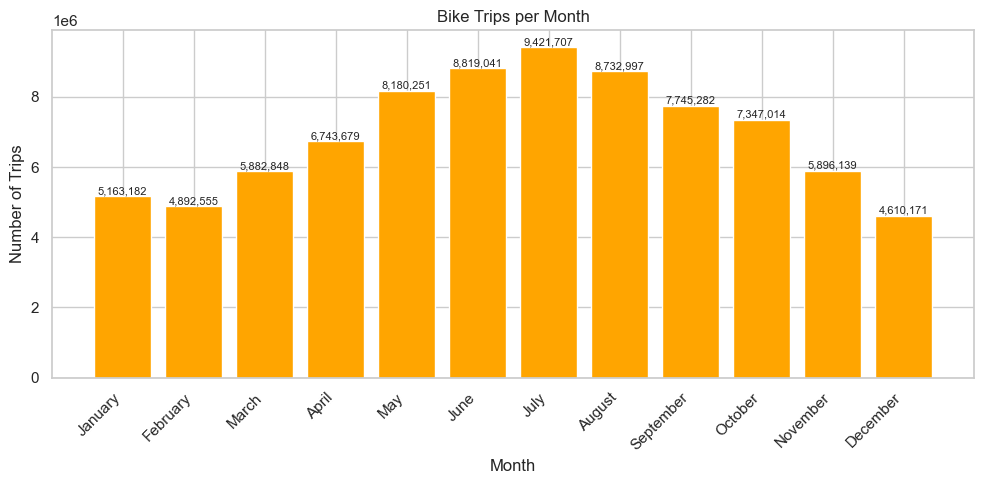

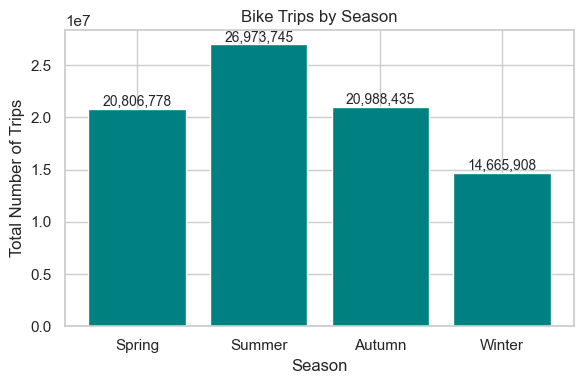

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import calendar

# demand_cycle_hire["month"] contains values like "January", "February", etc.

# 1) Map month name → month number
month_map = {name: num for num, name in enumerate(calendar.month_name) if name}
demand_cycle_hire["month_num"] = demand_cycle_hire["month"].map(month_map)

# 2) Define season mapping based on month number
season_map = {
    12: "Winter", 1: "Winter", 2: "Winter",
     3: "Spring", 4: "Spring", 5: "Spring",
     6: "Summer", 7: "Summer", 8: "Summer",
     9: "Autumn",10: "Autumn",11: "Autumn"
}
demand_cycle_hire["season"] = demand_cycle_hire["month_num"].map(season_map)

# 3) Aggregate seasonal demand in the desired order
season_order = ["Spring", "Summer", "Autumn", "Winter"]
seasonal_demand = (
    demand_cycle_hire
    .groupby("season", sort=False)["number_trips"]
    .sum()
    .reindex(season_order)
    .reset_index()
)

# 4) Re-order the monthly DataFrame by month_num for plotting
monthly = demand_cycle_hire.sort_values("month_num")

# --- Plot monthly demand ---
plt.figure(figsize=(10, 5))
bars = plt.bar(
    monthly["month"],
    monthly["number_trips"],
    color="orange"
)
plt.title("Bike Trips per Month")
plt.xlabel("Month")
plt.ylabel("Number of Trips")
plt.xticks(rotation=45, ha="right")
for bar in bars:
    h = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, h,
        f"{h:,.0f}",
        ha="center", va="bottom", fontsize=8
    )
plt.tight_layout()
plt.show()

# --- Plot seasonal demand ---
plt.figure(figsize=(6, 4))
bars = plt.bar(
    seasonal_demand["season"],
    seasonal_demand["number_trips"],
    color="teal"
)
plt.title("Bike Trips by Season")
plt.xlabel("Season")
plt.ylabel("Total Number of Trips")
for bar in bars:
    h = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, h,
        f"{h:,.0f}",
        ha="center", va="bottom", fontsize=10
    )
plt.tight_layout()
plt.show()


In [95]:
# Compute percentage share of total trips by season
seasonal_demand["percent"] = (
    seasonal_demand["number_trips"] 
    / seasonal_demand["number_trips"].sum() 
    * 100
).round(2)

# Show the results
print(seasonal_demand)


   season  number_trips  percent
0  Spring      20806778    24.94
1  Summer      26973745    32.33
2  Autumn      20988435    25.16
3  Winter      14665908    17.58


Bike Hire Weekly Demand

In [23]:
# Ensure start_date is datetime
valid_trip_df["start_date"] = pd.to_datetime(valid_trip_df["start_date"], errors='coerce')

# Extract day of week (1=Sunday, 7=Saturday), and weekday name
valid_trip_df["wk_index"] = valid_trip_df["start_date"].dt.dayofweek + 1  # Make 1=Mon ... 7=Sun (to match BigQuery)
valid_trip_df["weekday_name"] = valid_trip_df["start_date"].dt.day_name()

# Group and count
weekday_trips = (
    valid_trip_df
    .groupby(["wk_index", "weekday_name"])
    .size()
    .reset_index(name="number_trips")
    .sort_values("wk_index")
    .reset_index(drop=True)
)

# View result
weekday_trips

,wk_index,weekday_name,number_trips
0,1,Monday,1084604
1,2,Tuesday,1185911
2,3,Wednesday,1184247
3,4,Thursday,1217313
4,5,Friday,1173584
5,6,Saturday,1220291
6,7,Sunday,1037541


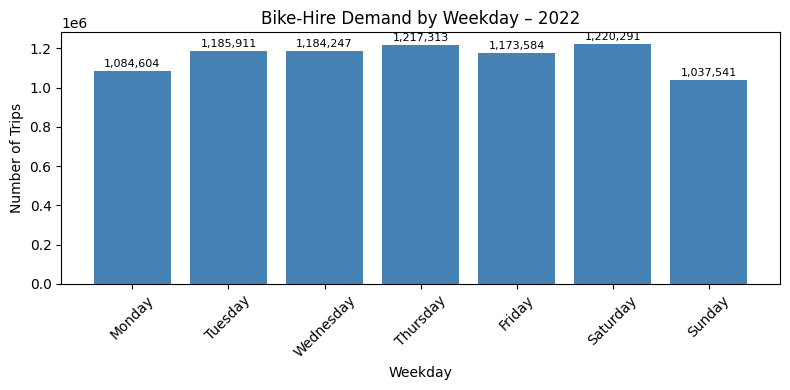

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
bars = plt.bar(weekday_trips["weekday_name"], weekday_trips["number_trips"], color="steelblue")
plt.title("Bike-Hire Demand by Weekday – 2022")
plt.xlabel("Weekday")
plt.ylabel("Number of Trips")

# Add data labels on each bar
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.01 * height,  # nudge label above bar
        f"{height:,.0f}",
        ha="center",
        va="bottom",
        fontsize=8
    )

plt.xticks(rotation=45)  # Optional: angle labels slightly
plt.tight_layout()
plt.show()


Top-10 start stations by trip count Most Recent Complete Year 2022

In [25]:
# Group by start station name and count trips
top10_start_2022 = (
    valid_trip_df
    .groupby("start_station_name")
    .size()
    .reset_index(name="trips")
    .sort_values("trips", ascending=False)
    .head(10)
    .reset_index(drop=True)
)

# View result
top10_start_2022


,start_station_name,trips
0,"Hyde Park Corner, Hyde Park",70147
1,"Albert Gate, Hyde Park",43742
2,"Wellington Arch, Hyde Park",39044
3,"Belgrove Street , King's Cross",38203
4,"Black Lion Gate, Kensington Gardens",37177
5,"Hop Exchange, The Borough",36307
6,"Wormwood Street, Liverpool Street",35243
7,"Waterloo Station 3, Waterloo",35222
8,"Serpentine Car Park, Hyde Park",34658
9,"Duke Street Hill, London Bridge",34499


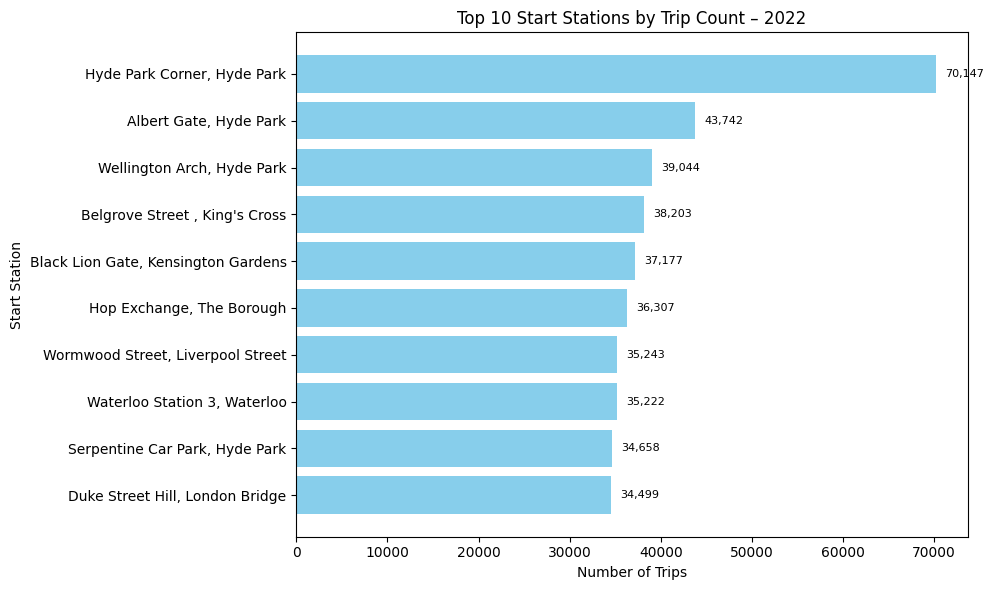

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
bars = plt.barh(top10_start_2022["start_station_name"], top10_start_2022["trips"], color="skyblue")
plt.title("Top 10 Start Stations by Trip Count – 2022")
plt.xlabel("Number of Trips")
plt.ylabel("Start Station")
plt.gca().invert_yaxis()  # Highest value on top

# Add labels to bars
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + 1000,  # adjust based on scale
        bar.get_y() + bar.get_height() / 2,
        f"{width:,.0f}",
        va="center",
        fontsize=8
    )

plt.tight_layout()
plt.show()


Top 10 End Stations by Trip Count Most Recent Complete Year 2022

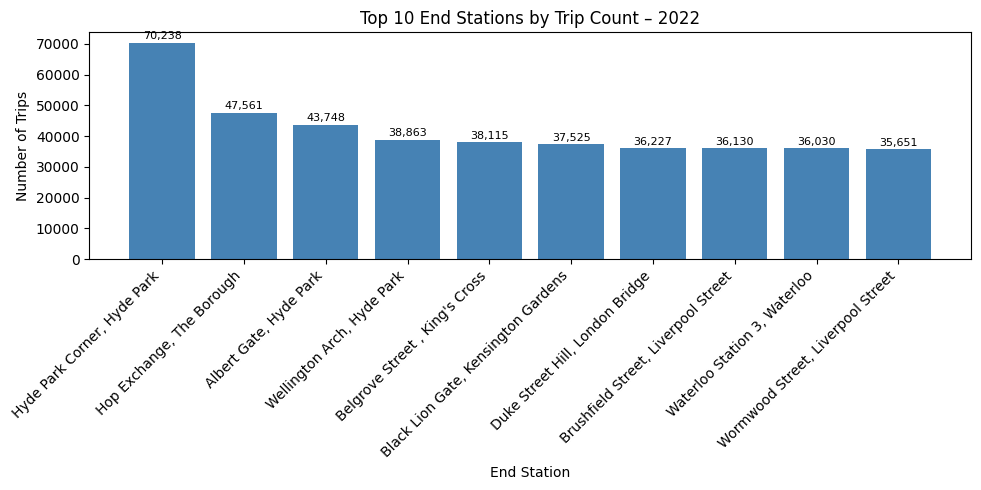

In [27]:
# 1. Top 10 End Stations by Trip Count
df_top10_end_2022 = (
    valid_trip_df
    .groupby(["end_station_id", "end_station_name"])
    .size()
    .reset_index(name="trips")
    .sort_values("trips", ascending=False)
    .head(10)
)

# Plot each chart
plot_vertical_bar_chart(df_top10_end_2022, "end_station_name", "trips", "Top 10 End Stations by Trip Count – 2022", "End Station", "Number of Trips")


In [28]:
df_top10_end_2022

,end_station_id,end_station_name,trips
179,191,"Hyde Park Corner, Hyde Park",70238
182,194,"Hop Exchange, The Borough",47561
284,303,"Albert Gate, Hyde Park",43748
199,213,"Wellington Arch, Hyde Park",38863
13,14,"Belgrove Street , King's Cross",38115
286,307,"Black Lion Gate, Kensington Gardens",37525
678,732,"Duke Street Hill, London Bridge",36227
236,251,"Brushfield Street, Liverpool Street",36130
145,154,"Waterloo Station 3, Waterloo",36030
203,217,"Wormwood Street, Liverpool Street",35651


Station with the shortest total duration of trips by station (2022)

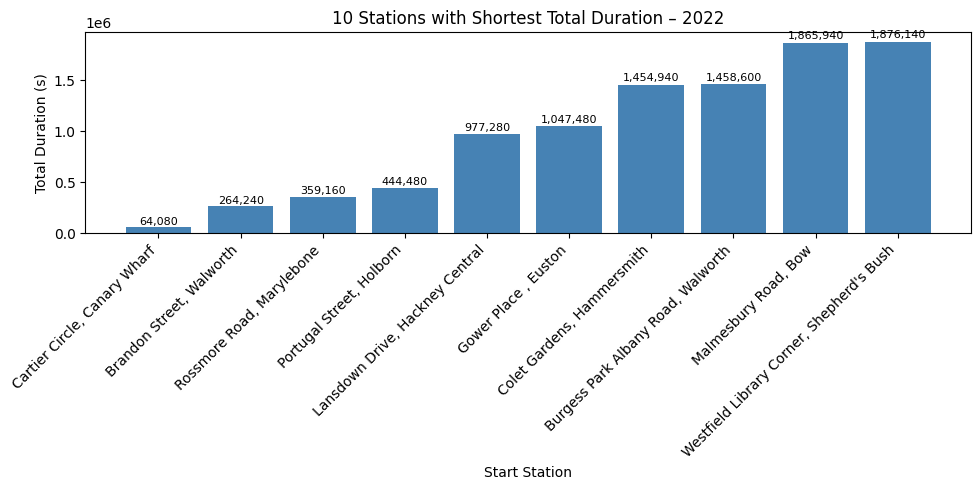

In [29]:
# 2. 10 Stations with Shortest Total Duration
df_shortest_total_2022 = (
    valid_trip_df
    .groupby(["start_station_id", "start_station_name"])["duration"]
    .sum()
    .reset_index(name="total_duration_seconds")
    .sort_values("total_duration_seconds")
    .head(10)
)

plot_vertical_bar_chart(df_shortest_total_2022, "start_station_name", "total_duration_seconds", "10 Stations with Shortest Total Duration – 2022", "Start Station", "Total Duration (s)")


In [30]:
df_shortest_total_2022

,start_station_id,start_station_name,total_duration_seconds
480,525,"Cartier Circle, Canary Wharf",64080
780,850,"Brandon Street, Walworth",264240
705,760,"Rossmore Road, Marylebone",359160
138,147,"Portugal Street, Holborn",444480
20,21,"Lansdown Drive, Hackney Central",977280
61,65,"Gower Place , Euston",1047480
558,608,"Colet Gardens, Hammersmith",1454940
779,846,"Burgess Park Albany Road, Walworth",1458600
428,472,"Malmesbury Road, Bow",1865940
541,591,"Westfield Library Corner, Shepherd's Bush",1876140


Stations with the longest total duration of trips (2022)

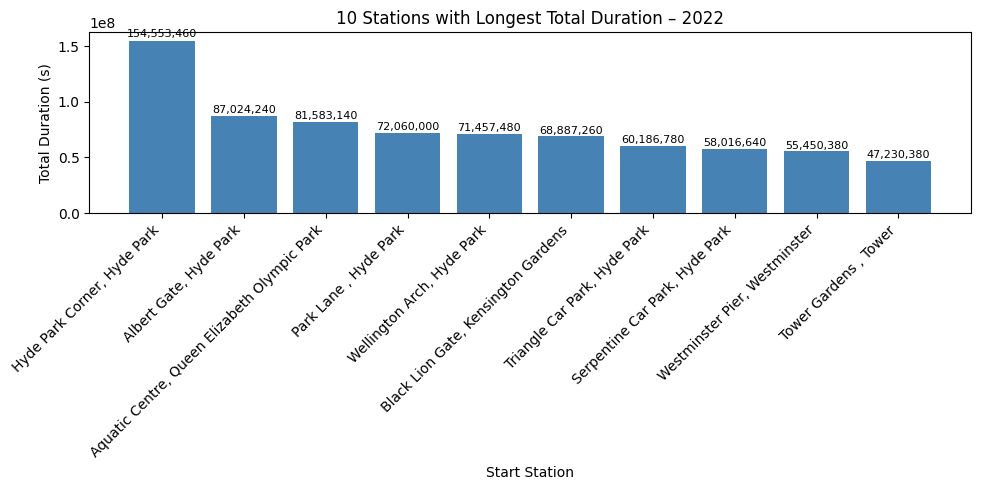

In [31]:
# 3. 10 Stations with Longest Total Duration
df_longest_total_2022 = (
    valid_trip_df
    .groupby(["start_station_id", "start_station_name"])["duration"]
    .sum()
    .reset_index(name="total_duration_seconds")
    .sort_values("total_duration_seconds", ascending=False)
    .head(10)
)

plot_vertical_bar_chart(df_longest_total_2022, "start_station_name", "total_duration_seconds", "10 Stations with Longest Total Duration – 2022", "Start Station", "Total Duration (s)")

In [32]:
df_longest_total_2022

,start_station_id,start_station_name,total_duration_seconds
179,191,"Hyde Park Corner, Hyde Park",154553460
284,303,"Albert Gate, Hyde Park",87024240
727,785,"Aquatic Centre, Queen Elizabeth Olympic Park",81583140
103,111,"Park Lane , Hyde Park",72060000
199,213,"Wellington Arch, Hyde Park",71457480
286,307,"Black Lion Gate, Kensington Gardens",68887260
233,248,"Triangle Car Park, Hyde Park",60186780
281,300,"Serpentine Car Park, Hyde Park",58016640
757,818,"Westminster Pier, Westminster",55450380
122,130,"Tower Gardens , Tower",47230380


Station with the highest average trip duration - 2022


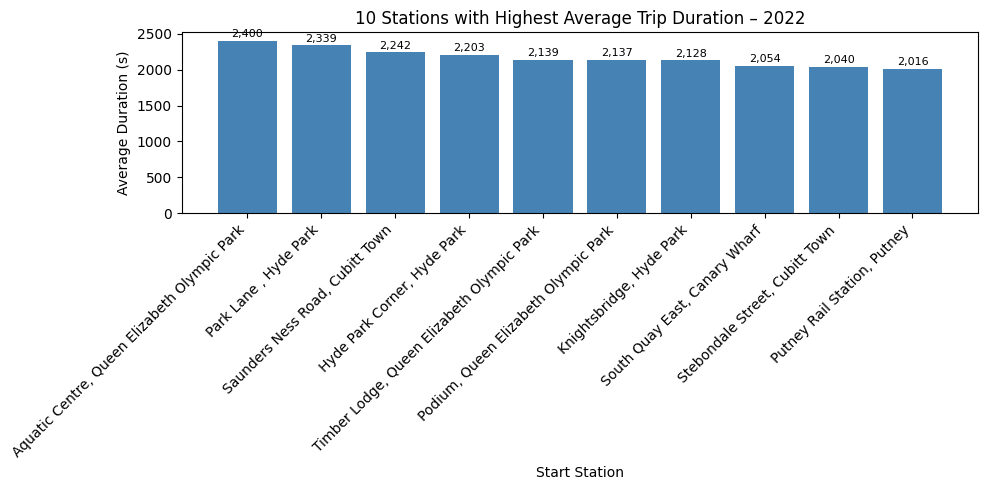

In [33]:
#10 Stations with Highest Average Trip Duration
df_highest_avg = (
    valid_trip_df
    .groupby(["start_station_id", "start_station_name"])["duration"]
    .mean()
    .reset_index(name="avg_duration_seconds")
    .sort_values("avg_duration_seconds", ascending=False)
    .head(10)
)
plot_vertical_bar_chart(df_highest_avg, "start_station_name", "avg_duration_seconds", "10 Stations with Highest Average Trip Duration – 2022", "Start Station", "Average Duration (s)")

In [34]:
df_highest_avg

,start_station_id,start_station_name,avg_duration_seconds
727,785,"Aquatic Centre, Queen Elizabeth Olympic Park",2399.574693
103,111,"Park Lane , Hyde Park",2339.078781
437,481,"Saunders Ness Road, Cubitt Town",2242.322939
179,191,"Hyde Park Corner, Hyde Park",2203.279684
729,787,"Timber Lodge, Queen Elizabeth Olympic Park",2138.852224
731,789,"Podium, Queen Elizabeth Olympic Park",2137.136415
208,222,"Knightsbridge, Hyde Park",2127.782739
449,494,"South Quay East, Canary Wharf",2054.303243
432,476,"Stebondale Street, Cubitt Town",2039.562753
640,694,"Putney Rail Station, Putney",2015.676101


# Station with the lowest average trip duration 2022


In [35]:
# 1. Lowest average trip duration
df_lowest_avg = (
    valid_trip_df
    .groupby(["start_station_id", "start_station_name"])["duration"]
    .mean()
    .reset_index(name="avg_duration_seconds")
    .sort_values("avg_duration_seconds", ascending=True)
    .head(10)
)

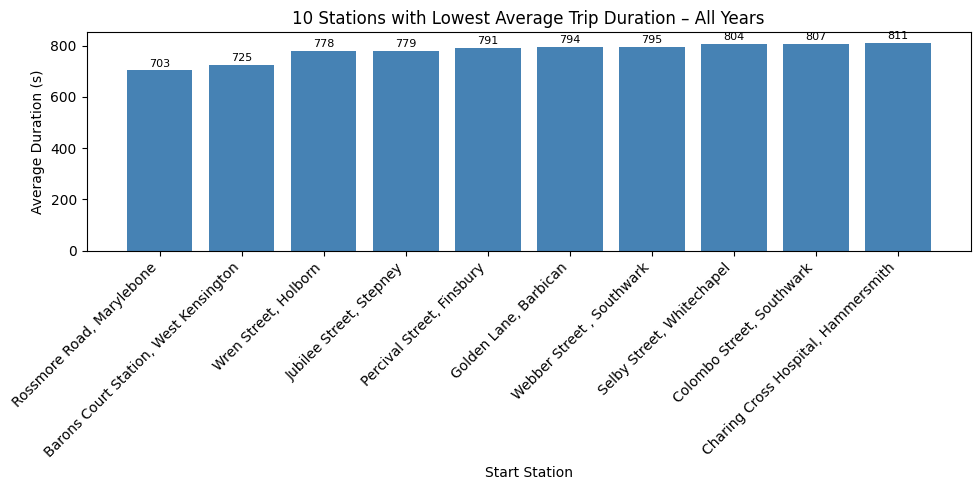

In [36]:
plot_vertical_bar_chart(df_lowest_avg,"start_station_name","avg_duration_seconds","10 Stations with Lowest Average Trip Duration – 2022","Start Station","Average Duration (s)")


Busiest station at commuter peak hours (7–9 AM & 5–7 PM) — 2022 only


End station and Start Station peak at certain times - I wanted to be able to get the business of the stations during commuter hours giving a window of 
7-9am and 5-7pm Monday to Friday

for Saturday and Sunday I had derived the busiest times off the back of finding out the number of trips in a 3hr window

Identifying peak hours for the weekend

In [37]:
import numpy as np
import pandas as pd

# ---------- Start Station Peak Windows ----------
start_df = valid_trip_df[
    valid_trip_df["start_date"].dt.dayofweek.isin([5, 6])
].copy()

start_df["hour"] = start_df["start_date"].dt.hour
start_df["weekday"] = start_df["start_date"].dt.day_name()

bins = list(range(0, 24, 3))
labels = [f"{str(b).zfill(2)}-{str(b + 3).zfill(2)}" for b in bins]
start_df["window_label"] = pd.cut(
    start_df["hour"],
    bins=bins + [24],
    labels=labels,
    right=False,
    include_lowest=True
)

start_df["period"] = np.where(
    start_df["hour"].between(6, 11), "morning_peak",
    np.where(start_df["hour"].between(15, 20), "evening_peak", None)
)

start_peak_df = start_df[start_df["period"].notna()].copy()

df_weekend_start_peaks = (
    start_peak_df
    .groupby(["weekday", "period", "window_label"])
    .size()
    .reset_index(name="trips")
    .sort_values(["weekday", "period", "trips"], ascending=[True, True, False])
    .groupby(["weekday", "period"])
    .head(1)
    .reset_index(drop=True)
)


# ---------- End Station Peak Windows ----------
end_df = valid_trip_df[
    valid_trip_df["end_date"].dt.dayofweek.isin([5, 6])
].copy()

end_df["hour"] = end_df["end_date"].dt.hour
end_df["weekday"] = end_df["end_date"].dt.day_name()

end_df["window_label"] = pd.cut(
    end_df["hour"],
    bins=bins + [24],
    labels=labels,
    right=False,
    include_lowest=True
)

end_df["period"] = np.where(
    end_df["hour"].between(6, 11), "morning_peak",
    np.where(end_df["hour"].between(15, 20), "evening_peak", None)
)

end_peak_df = end_df[end_df["period"].notna()].copy()

df_weekend_end_peaks = (
    end_peak_df
    .groupby(["weekday", "period", "window_label"])
    .size()
    .reset_index(name="trips")
    .sort_values(["weekday", "period", "trips"], ascending=[True, True, False])
    .groupby(["weekday", "period"])
    .head(1)
    .reset_index(drop=True)
)


C:\Users\msidh\AppData\Local\Temp\ipykernel_32716\3563178989.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["weekday", "period", "window_label"])
C:\Users\msidh\AppData\Local\Temp\ipykernel_32716\3563178989.py:66: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["weekday", "period", "window_label"])


In [38]:
df_weekend_start_peaks

,weekday,period,window_label,trips
0,Saturday,evening_peak,15-18,298405
1,Saturday,morning_peak,09-12,197811
2,Sunday,evening_peak,15-18,255671
3,Sunday,morning_peak,09-12,172451


In [39]:
df_weekend_end_peaks

,weekday,period,window_label,trips
0,Saturday,evening_peak,15-18,302760
1,Saturday,morning_peak,09-12,175052
2,Sunday,evening_peak,15-18,261204
3,Sunday,morning_peak,09-12,148977


Weekday Peak Times

In [8]:
import numpy as np
import pandas as pd

# Define your 3-hour bins and labels once
bins = list(range(0, 24, 3))
labels = [f"{str(b).zfill(2)}-{str(b + 3).zfill(2)}" for b in bins]

# ---------- Start Station Peak Windows (Weekdays) ----------
start_df = valid_trip_df[
    valid_trip_df["start_date"].dt.weekday < 5  # Mon–Fri (0–4)
].copy()

start_df["hour"] = start_df["start_date"].dt.hour
start_df["weekday"] = start_df["start_date"].dt.day_name()

start_df["window_label"] = pd.cut(
    start_df["hour"],
    bins=bins + [24],
    labels=labels,
    right=False,
    include_lowest=True
)

start_df["period"] = np.where(
    start_df["hour"].between(6, 11), "morning_peak",
    np.where(start_df["hour"].between(15, 20), "evening_peak", None)
)

start_peak_df = start_df[start_df["period"].notna()].copy()

df_weekday_start_peaks = (
    start_peak_df
    .groupby(["weekday", "period", "window_label"])
    .size()
    .reset_index(name="trips")
    .sort_values(["weekday", "period", "trips"], ascending=[True, True, False])
    .groupby(["weekday", "period"])
    .head(1)
    .reset_index(drop=True)
)


# ---------- End Station Peak Windows (Weekdays) ----------
end_df = valid_trip_df[
    valid_trip_df["end_date"].dt.weekday < 5  # Mon–Fri (0–4)
].copy()

end_df["hour"] = end_df["end_date"].dt.hour
end_df["weekday"] = end_df["end_date"].dt.day_name()

end_df["window_label"] = pd.cut(
    end_df["hour"],
    bins=bins + [24],
    labels=labels,
    right=False,
    include_lowest=True
)

end_df["period"] = np.where(
    end_df["hour"].between(6, 11), "morning_peak",
    np.where(end_df["hour"].between(15, 20), "evening_peak", None)
)

end_peak_df = end_df[end_df["period"].notna()].copy()

df_weekday_end_peaks = (
    end_peak_df
    .groupby(["weekday", "period", "window_label"])
    .size()
    .reset_index(name="trips")
    .sort_values(["weekday", "period", "trips"], ascending=[True, True, False])
    .groupby(["weekday", "period"])
    .head(1)
    .reset_index(drop=True)
)


C:\Users\msidh\AppData\Local\Temp\ipykernel_32064\3875528767.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["weekday", "period", "window_label"])
C:\Users\msidh\AppData\Local\Temp\ipykernel_32064\3875528767.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["weekday", "period", "window_label"])


In [9]:
df_weekday_start_peaks

,weekday,period,window_label,trips
0,Friday,evening_peak,15-18,267891
1,Friday,morning_peak,06-09,163185
2,Monday,evening_peak,15-18,249025
3,Monday,morning_peak,06-09,175436
4,Thursday,evening_peak,18-21,270964
5,Thursday,morning_peak,06-09,218924
6,Tuesday,evening_peak,18-21,279839
7,Tuesday,morning_peak,06-09,233666
8,Wednesday,evening_peak,18-21,268705
9,Wednesday,morning_peak,06-09,234160


In [10]:
df_weekday_end_peaks

,weekday,period,window_label,trips
0,Friday,evening_peak,18-21,265714
1,Friday,morning_peak,09-12,161105
2,Monday,evening_peak,18-21,268779
3,Monday,morning_peak,06-09,155382
4,Thursday,evening_peak,18-21,294063
5,Thursday,morning_peak,06-09,192628
6,Tuesday,evening_peak,18-21,305515
7,Tuesday,morning_peak,06-09,206546
8,Wednesday,evening_peak,18-21,291001
9,Wednesday,morning_peak,06-09,207151


Most Active Start Stations Weekday

In [40]:
# Most active start stations on weekdays
start_weekday_df = valid_trip_df[
    (valid_trip_df["start_date"].dt.dayofweek.between(0, 4)) &
    (valid_trip_df["start_date"].dt.hour.isin([7, 8, 9, 17, 18, 19]))
].copy()

start_weekday_df["peak_period"] = np.where(
    start_weekday_df["start_date"].dt.hour.between(7, 9), "morning_peak", "evening_peak"
)

df_start_weekday = (
    start_weekday_df
    .groupby(["peak_period", "start_station_id", "start_station_name"])
    .size()
    .reset_index(name="trips")
    .sort_values(["peak_period", "trips"], ascending=[True, False])
    .groupby("peak_period")
    .head(5)
    .reset_index(drop=True)
)


In [41]:
df_start_weekday

,peak_period,start_station_id,start_station_name,trips
0,evening_peak,191,"Hyde Park Corner, Hyde Park",11464
1,evening_peak,217,"Wormwood Street, Liverpool Street",9558
2,evening_peak,228,"St. James's Square, St. James's",8835
3,evening_peak,579,"Queen Street 2, Bank",8784
4,evening_peak,251,"Brushfield Street, Liverpool Street",8023
5,morning_peak,154,"Waterloo Station 3, Waterloo",23433
6,morning_peak,374,"Waterloo Station 1, Waterloo",15171
7,morning_peak,14,"Belgrove Street , King's Cross",15131
8,morning_peak,361,"Waterloo Station 2, Waterloo",11491
9,morning_peak,217,"Wormwood Street, Liverpool Street",8435


Start Station Weekend

In [42]:
# Filter for start trips on weekends within defined peak hours
start_weekend_df = valid_trip_df[
    (valid_trip_df["start_date"].dt.dayofweek.isin([5, 6])) &
    (valid_trip_df["start_date"].dt.hour.isin([9, 10, 11, 15, 16, 17]))
].copy()

# Assign peak period label based on hour
start_weekend_df["peak_period"] = np.where(
    start_weekend_df["start_date"].dt.hour.between(9, 11), "morning_peak", "evening_peak"
)

# Group and get top 5 stations per peak period
df_start_weekend = (
    start_weekend_df
    .groupby(["peak_period", "start_station_id", "start_station_name"])
    .size()
    .reset_index(name="trips")
    .sort_values(["peak_period", "trips"], ascending=[True, False])
    .groupby("peak_period")
    .head(5)
    .reset_index(drop=True)
)


In [43]:
df_start_weekend

,peak_period,start_station_id,start_station_name,trips
0,evening_peak,191,"Hyde Park Corner, Hyde Park",8849
1,evening_peak,303,"Albert Gate, Hyde Park",5209
2,evening_peak,213,"Wellington Arch, Hyde Park",4392
3,evening_peak,300,"Serpentine Car Park, Hyde Park",4366
4,evening_peak,111,"Park Lane , Hyde Park",4289
5,morning_peak,191,"Hyde Park Corner, Hyde Park",3638
6,morning_peak,307,"Black Lion Gate, Kensington Gardens",2601
7,morning_peak,213,"Wellington Arch, Hyde Park",2247
8,morning_peak,303,"Albert Gate, Hyde Park",2160
9,morning_peak,300,"Serpentine Car Park, Hyde Park",2092


End Station Weekday

In [44]:
# Most active end stations on weekdays
end_weekday_df = valid_trip_df[
    (valid_trip_df["end_date"].dt.dayofweek.between(0, 4)) &
    (valid_trip_df["end_date"].dt.hour.isin([7, 8, 9, 17, 18, 19]))
].copy()

end_weekday_df["peak_period"] = np.where(
    end_weekday_df["end_date"].dt.hour.between(7, 9), "morning_peak", "evening_peak"
)

df_end_weekday = (
    end_weekday_df
    .groupby(["peak_period", "end_station_id", "end_station_name"])
    .size()
    .reset_index(name="trips")
    .sort_values(["peak_period", "trips"], ascending=[True, False])
    .groupby("peak_period")
    .head(5)
    .reset_index(drop=True)
)


In [45]:
df_end_weekday

,peak_period,end_station_id,end_station_name,trips
0,evening_peak,154,"Waterloo Station 3, Waterloo",23391
1,evening_peak,14,"Belgrove Street , King's Cross",14091
2,evening_peak,191,"Hyde Park Corner, Hyde Park",11266
3,evening_peak,361,"Waterloo Station 2, Waterloo",10498
4,evening_peak,374,"Waterloo Station 1, Waterloo",10491
5,morning_peak,66,"Holborn Circus, Holborn",12045
6,morning_peak,101,"Queen Street 1, Bank",11108
7,morning_peak,228,"St. James's Square, St. James's",11033
8,morning_peak,217,"Wormwood Street, Liverpool Street",9621
9,morning_peak,579,"Queen Street 2, Bank",9520


End Station Weekend

In [46]:
# Filter for end trips on weekends within defined peak hours
end_weekend_df = valid_trip_df[
    (valid_trip_df["end_date"].dt.dayofweek.isin([5, 6])) &
    (valid_trip_df["end_date"].dt.hour.isin([9, 10, 11, 15, 16, 17]))
].copy()

# Assign peak period label based on hour
end_weekend_df["peak_period"] = np.where(
    end_weekend_df["end_date"].dt.hour.between(9, 11), "morning_peak", "evening_peak"
)

# Group and get top 5 stations per peak period
df_end_weekend = (
    end_weekend_df
    .groupby(["peak_period", "end_station_id", "end_station_name"])
    .size()
    .reset_index(name="trips")
    .sort_values(["peak_period", "trips"], ascending=[True, False])
    .groupby("peak_period")
    .head(5)
    .reset_index(drop=True)
)


In [47]:
df_end_weekend

,peak_period,end_station_id,end_station_name,trips
0,evening_peak,191,"Hyde Park Corner, Hyde Park",9166
1,evening_peak,303,"Albert Gate, Hyde Park",5365
2,evening_peak,307,"Black Lion Gate, Kensington Gardens",4510
3,evening_peak,111,"Park Lane , Hyde Park",4438
4,evening_peak,213,"Wellington Arch, Hyde Park",4365
5,morning_peak,191,"Hyde Park Corner, Hyde Park",3435
6,morning_peak,194,"Hop Exchange, The Borough",2931
7,morning_peak,303,"Albert Gate, Hyde Park",2232
8,morning_peak,213,"Wellington Arch, Hyde Park",2231
9,morning_peak,307,"Black Lion Gate, Kensington Gardens",2110


Find the 5 closest stations to one another using Cycling Station df

In [48]:
from sklearn.neighbors import BallTree
import numpy as np, pandas as pd

# lat/lon must be in **radians**
latlon_rad = np.radians(cycle_stations_df[["latitude", "longitude"]].to_numpy())
tree = BallTree(latlon_rad, metric='haversine')

# Query the 6 nearest (incl. self) for the first five rows
dist_rad, idx = tree.query(latlon_rad[:5], k=6)
dist_m  = dist_rad * 6_371_000        # convert radians → metres

for origin_row, neighbours, dists in zip(range(5), idx, dist_m):
    nn_idx = neighbours[1:]           # skip self
    nearest = (cycle_stations_df
               .iloc[nn_idx][["name", "latitude", "longitude"]]
               .assign(distance_m = dists[1:].round(1)))
    print(f"\nOrigin: {cycle_stations_df.iloc[origin_row]['name']}")
    display(nearest)



Origin: Museum of London, Barbican


,name,latitude,longitude,distance_m
589,"Wood Street, Guildhall",51.517008,-0.093885,202.1
656,"King Edward Street, St Pauls",51.516010,-0.098500,244.5
471,"West Smithfield Rotunda, Farringdon",51.518219,-0.100791,300.4
792,"Newgate Street , St. Paul's",51.515768,-0.099894,327.7
588,"The Guildhall, Guildhall",51.515735,-0.093081,331.2



Origin: Queen Victoria Street, St. Paul's


,name,latitude,longitude,distance_m
737,"Godliman Street, St. Paul's",51.512484,-0.099141,131.2
11,"Queen Street 2, Bank",51.511246,-0.093051,314.1
702,"Queen Street 1, Bank",51.511553,-0.092940,314.8
6,"Cheapside, Bank",51.513971,-0.092940,383.3
793,"Blackfriars Station, St. Paul's",51.511934,-0.103079,390.1



Origin: Finsbury Square , Moorgate


,name,latitude,longitude,distance_m
783,"Christopher Street, Liverpool Street",51.521284,-0.084606,79.6
724,"Pindar Street, Liverpool Street",51.520955,-0.083494,148.1
727,"Sun Street, Liverpool Street",51.520009,-0.083936,158.3
3,"Moorfields, Moorgate",51.519069,-0.088285,279.2
773,"Bunhill Row, Moorgate",51.520859,-0.089888,294.5



Origin: Moorfields, Moorgate


,name,latitude,longitude,distance_m
634,"Fore Street Avenue, Guildhall",51.517842,-0.090075,184.3
773,"Bunhill Row, Moorgate",51.520859,-0.089888,227.8
716,"Fore Street, Guildhall",51.518093,-0.091402,241.4
784,"Finsbury Circus, Liverpool Street",51.517075,-0.086686,247.8
2,"Finsbury Square , Moorgate",51.520963,-0.085634,279.2



Origin: Queen's Gate (North), Kensington


,name,latitude,longitude,distance_m
576,"Queen's Gate, Kensington Gardens",51.501715,-0.179854,81.2
713,"Kensington Gore, Knightsbridge",51.501433,-0.178657,118.9
654,"Imperial College, Knightsbridge",51.499429,-0.179702,181.6
613,"Prince Consort Road, Knightsbridge",51.499807,-0.176416,297.8
233,"Palace Gate, Kensington Gardens",51.502042,-0.184400,308.9


In [ ]:
# -------------------------------
# Build a BallTree on ALL stations
# -------------------------------
latlon_rad = np.radians(cycle_stations_df[["latitude", "longitude"]].to_numpy())
tree       = BallTree(latlon_rad, metric="haversine")

# -------------------------------------------------
# Locate Hyde Park Corner (ID 191) in the dataframe
# -------------------------------------------------
origin_idx = cycle_stations_df.index[cycle_stations_df["id"] == 191][0]

# -----------------------------------
# Query the 6 nearest (incl. itself)
# -----------------------------------
dist_rad, idx = tree.query(latlon_rad[origin_idx].reshape(1, -1), k=6)
dist_m = (dist_rad[0] * 6_371_000).round(1)          # convert to metres

# -----------------------------------
# Build neighbours dataframe
# -----------------------------------
nn_idx  = idx[0][1:]   # skip itself
nearest = (cycle_stations_df
           .iloc[nn_idx][["name", "latitude", "longitude"]]
           .assign(distance_m = dist_m[1:]))

print(f"\nOrigin: {cycle_stations_df.loc[origin_idx, 'name']} (ID 191)")
display(nearest)


Origin: Hyde Park Corner, Hyde Park (ID 191)


,name,latitude,longitude,distance_m
265,"Knightsbridge, Hyde Park",51.502757,-0.155350,132.8
612,"Grosvenor Crescent, Belgravia",51.501353,-0.153195,197.6
696,"Wellington Arch, Hyde Park",51.502740,-0.149569,276.7
508,"Park Lane, Mayfair",51.505426,-0.150817,317.6
767,"Albert Gate, Hyde Park",51.502954,-0.158456,342.1
